In [147]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

#!pip install webcolors
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

# print(torch.cuda.get_device_name(0))
# print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True


## 데이터 전처리 함수 정의 (Dataset)

In [148]:
category_names = ['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
dataset_path  = '/opt/ml/input/data'

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)

    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [149]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/train.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2(),
                            ])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=1,
                                           shuffle=False,
                                           num_workers=4,
                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.66s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [150]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [151]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

### `plot_examples()` 시각화 함수 정의

In [152]:
def plot_examples(mode="train", batch_id=0, num_examples=1, dataloaer=train_loader, aug=None):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    # model.eval()
                    # # inference
                    # outs = model(torch.stack(temp_images).to(device))['out']
                    # oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples*2, ncols=2, figsize=(8, 8*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            img = temp_images[row_num].permute([1,2,0]).numpy()
            mask = masks[row_num].detach().cpu().numpy()
            augmented = aug(image=img, mask=mask)
            # Original Image
            ax[row_num][0].imshow(img)
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num+ 1][0].imshow(label_to_color_image(mask))
            ax[row_num+ 1][0].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            if aug is not None:
                # Augmented Image
                ax[row_num][1].imshow(augmented['image'])
                ax[row_num][1].set_title(f"Augmented Image : {image_infos[row_num]['file_name']}")
                # Groud Truth
                ax[row_num+ 1][1].imshow(label_to_color_image(augmented['mask']))
                ax[row_num+ 1][1].set_title(f"Augmented Groud Truth : {image_infos[row_num]['file_name']}")

        plt.show()

# 적용시키고 싶은 Augmentation

In [176]:
trans = A.Compose([
     # A.RandomSizedCrop((256-100, 256+100), 256, 256), #ok
     # A.ShiftScaleRotate(p=1), #ok
     # A.RGBShift(p=1), 
     # A.Blur(p=1), #ok
     # A.GaussNoise(p=1),
     # A.ElasticTransform(p=1),
     # A.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.1, hue=0.1,p=1), #ok
     A.MaskDropout(2, mask_fill_value=0, p=1), #ok
     # A.Cutout(p=1),
     # A.Normalize(max_pixel_value=1),
     # A.HorizontalFlip(p=1), #ok
     # A.CropNonEmptyMaskIfExists(50,50,p=1),
     # A.CenterCrop(300,300,p=1),
     # A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.4, p=1), # ok
     # A.RandomSnow(p=1),
     # A.RandomGridShuffle(grid=(2, 2), p=1),
     # A.Rotate(limit=45, p=1),
     # A.Transpose(p=1),
     # A.Perspective(p=1), # ok
     # A.GridDropout(p=1),
     # A.GridDistortion(p=1), # ok
     # A.ElasticTransform(p=1),
     # A.Affine(p=1), #ok
     # A.ChannelDropout(p=1),
     # A.CoarseDropout(p=1)
],p=1)

In [177]:
geom_trans = A.Compose( [A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, 
                       interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),
                    # D4 Group augmentations
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.Transpose(p=0.5),
                    # crop and resize  
                    A.RandomSizedCrop((256-100, 256+100), 512//2, 512//2, w2h_ratio=1.0, 
                                        interpolation=cv2.INTER_LINEAR, always_apply=False, p=0.5),  
                    A.Resize(512//2, 512//2, interpolation=cv2.INTER_LINEAR, p=1), 
                    #A.Normalize(),
                    ])

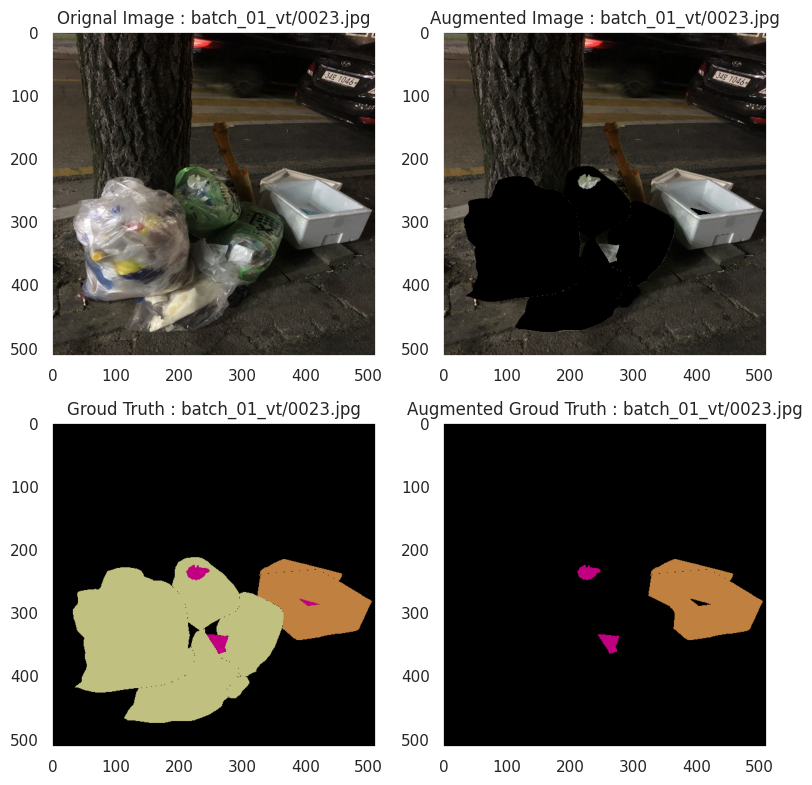

In [181]:
plot_examples(mode="train",
# batch_id=np.random.randint(0, len(train_loader)),      # 랜덤한 이미지가 보고싶다면!
batch_id= 13,                                                       # 하나의 고정된 이미지가 보고싶다면!
num_examples=1,                                                      # 1로 안하면 고장나는건 비밀
dataloaer=train_loader,
aug=trans)